In [46]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(7,5)
import sys
import math
import time
# Add the application folder to the path
sys.path.insert(0,'../Peergrade/peergrade/')

import application.model as data_model
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt

In [2]:
class Grader(object):
    def __init__(self, name):
        self.name = name
        self.handins = list()
        
    def add_handin(self, handin):
        self.handins.append(handin)

class Handin:
    def __init__(self,title,owner):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
    
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_gradeing(self,grader,value):
        self.gradeings[grader.name] = value

        
class Assignment(object):
    
    def __init__(self, handins_input, graders_input,n_gradings):
        self.handins = dict()
        self.graders = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
            
class Course(object):
    
    def __init__(self):
        self.assignments = list()
        self.handins = dict()
        self.graders = dict()
        self.n_gradings = 0
    
    def add_assignment(self,assignment):
        self.assignments.append(assignment)
        for a in self.assignments:
            self.handins.update(a.handins)
            self.graders.update(a.graders)
        self.n_gradings = self.n_gradings + a.n_gradings

In [3]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def user_id(user_name):
    for user in data_model.User.objects(name=user_name):
        return user.id

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            max_value = max(map(int,question.numericalAnswers.keys()))
            return max_value
        else:
            return 5

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def score_handin(report_grade):
    answers = data_model.Answer.objects(report_grade=report_grade)
    handin_n = 0.0
    handin_acc = 0.0
    for answer in answers:
        if answer.text_answer == None:
            handin_acc = handin_acc + answer_value(answer)
            handin_n = handin_n + 1.0
    return handin_acc / handin_n


In [4]:
def fetch_assignment_data(ass_obj):
    '''
    Takes an course and assignment data model object and transforms it into populated Assignment object
    Only student or all?
    '''

    ## Create dictionary for holding the graders who have graded a handin
    graders = dict()
    
    ## Find all handins
    handins = dict()
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        handins[str(handin_.id)] = Handin(str(handin_.id),str(handin_.submitter.id))
        
    ## Find all handins graders have graded and vice versa
    n_gradings = 0
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        for grade in data_model.ReportGrade.objects(handin=handin_,state='ANSWERED'):
            n_gradings = n_gradings + 1
            
            # Needed if TA or Professor have graded reports as they are not initialy part of it
            if str(grade.giver.id) not in graders:
                graders[str(grade.giver.id)] = Grader(str(grade.giver.id))

            handins[str(handin_.id)].add_grader(graders[str(grade.giver.id)])
            handins[str(handin_.id)].add_gradeing(graders[str(grade.giver.id)],score_handin(grade))
            
    ## update reference in graders
    for handin in handins.itervalues():
        for grader in handin.graders:
            grader.add_handin(handin)

    return Assignment(handins.itervalues(),graders.itervalues(),n_gradings)

In [5]:
def fetch_data(obj):

    res_c = Course()
        
    if type(obj).__name__ == "Course":
        assignments_d = data_model.Assignment.objects(course=obj)
        for assignment_d in assignments_d:
            res_c.add_assignment(fetch_assignment_data(assignment_d))
    elif type(obj).__name__ == "Assignment":
        res_c.add_assignment(fetch_assignment_data(obj))
        
    return res_c

In [6]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))-np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t)-0.5*t*la*(u-ga)**2

In [35]:
def MH_model(data,samples,burn_in=0):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    
    log_h = dict()
    log_g = dict()

    def prop_u_t_h(handin,u_h,t_h):
        sum_ = 0.0
        for g, val in handin.gradeings.iteritems():
            sum_ = sum_ + norm_log_pdf(val,u_g[g]+u_h,t_g[g]+t_h)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.gradeings[g]
            sum_ = sum_ + norm_log_pdf(val,u_g+u_h[h.title],t_g+t_h[h.title])
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    
    # Draw from priors
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
    # pre calcuate the liklyhood
    for h, handin in data.handins.iteritems():
        log_h[h] = prop_u_t_h(handin,u_h[h],t_h[h])
    for g, grader in data.graders.iteritems():
        log_g[g] =prop_u_t_g(grader,g,u_g[g],t_g[g])
        
    # Gibbs sampling
    
#    def ensure_postive(mean,sd):
#        r_ = np.random.normal(mean,sd)
#        while r_ <= 0:
#            r_ = np.random.normal(mean,sd)
#        return r_ 
    
    # Tracers initialising
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    ## Acception ratior
    accepted_h = 0.0
    accepted_g = 0.0

    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                accepted_h = accepted_h+1.0
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                accepted_g = accepted_g + 1.0
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in data.handins.iterkeys():
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in data.graders.iterkeys():
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}

    return traces

In [8]:
def handin_students(h_id):
    model_handin = data_model.Handin.objects.get(id=ObjectId(h_id))
    students_ = list()
    for student in model_handin.students:
        students_.append(student.name)
    return ", ".join(students_)

In [9]:
def truncate(string,length):
    return (string[:length] + '..') if len(string) > length else string

In [68]:
def plot_bias(t,result):
    figsize(11,20)
    scores = list()
    for name, g in t.graders.iteritems():
        text = truncate(user_name(ObjectId(name)),45)
        text = text + ": %i" % len(t.graders[name].handins)
        scores.append((text,np.mean(result['u_g'][name]),np.sqrt(1.0 /np.mean(result['t_g'][name]))))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    model_2 = map(lambda x : float(x[2]),scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.errorbar(model_1,y,xerr=model_2,fmt='or',label="MH sampling",alpha=0.65)

    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.xlim(-0.3,0.3)
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.autoscale(tight=True)
    plt.show()
    figsize(7,5)

In [76]:
def plot_handin_score(t,result):
    figsize(11,25)

    scores = list()
    for title, handin in t.handins.iteritems():
        l = truncate(handin_students(title),45)
        scores.append((l,np.mean(result['u_h'][title]),handin.gradeings.values(),np.sqrt(1.0 /np.mean(result['t_h'][title]))))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    mean = map(lambda x : x[2],scores)
    std = map(lambda x : x[3],scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
#    plt.plot(model_1,y,'or',label="Gibbs sampling")
    plt.boxplot(mean, positions=y, vert=False)
    plt.errorbar(model_1,y,xerr=std,fmt='or',label="MH sampling",alpha=0.65)
#    plt.plot(mean,y,'ob',label="Mean",alpha=0.65)

    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.autoscale(tight=True)
    plt.show()
    figsize(7,5)

In [96]:
def get_sorted_result(t,result):
    s = list()
    for name, g in t.graders.iteritems():
        s.append((user_name(ObjectId(name)),np.mean(result['u_g'][name])))
    s.sort(key=lambda x:x[1])
    return s

In [97]:
def get_sorted_result_T(t,result):
    s = list()
    for name, h in t.handins.iteritems():
        s.append((h,np.mean(result['u_h'][name])))
    s.sort(key=lambda x:x[1])
    return s

## The entire course

In [14]:
c = data_model.Course.objects.get(title="Computational Tools for Big Data")

In [15]:
course_data = fetch_data(c)

In [36]:
course_result = MH_model(course_data,1000)

1000 out of 1000
Wall time: 58.394052


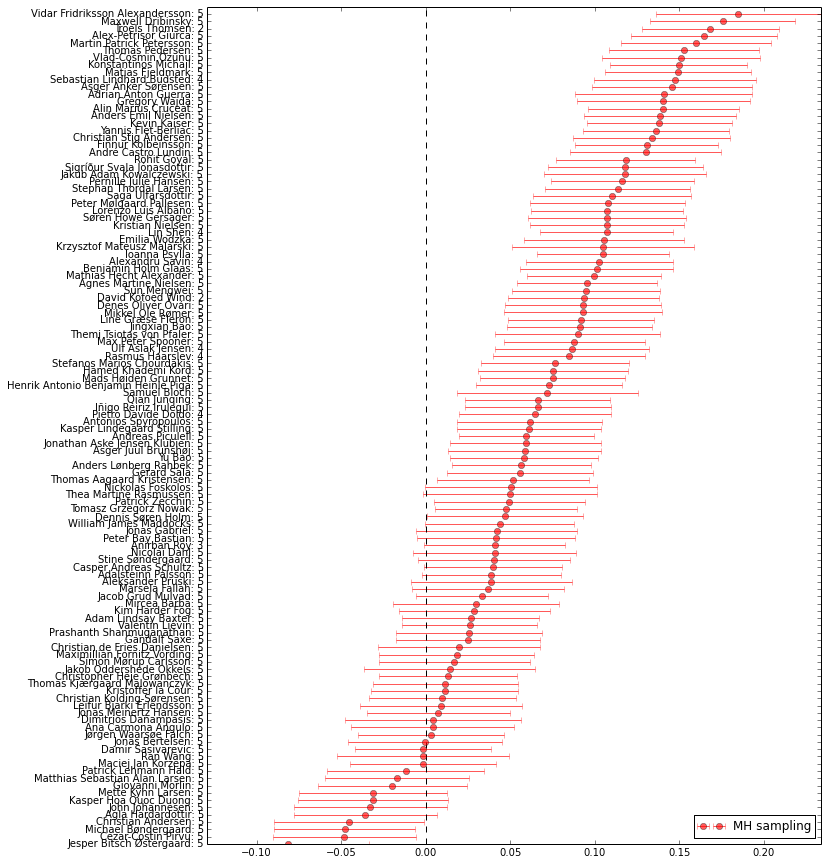

In [65]:
plot_bias(course_data,course_result)

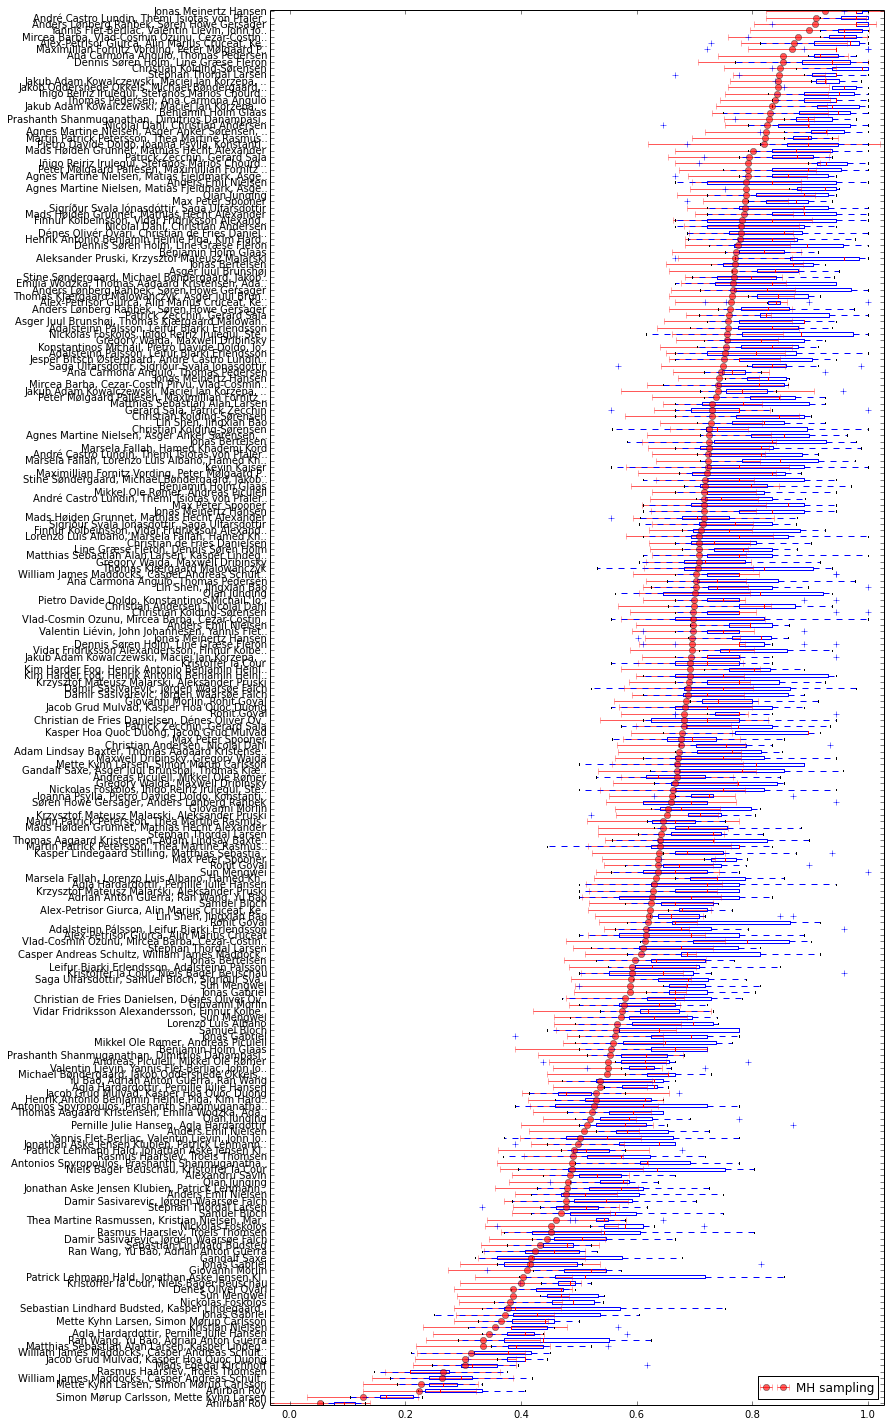

In [140]:
plot_handin_score(course_data,course_result)

## Assignment 1

In [109]:
a1 = data_model.Assignment.objects.get(title="UNIX, Python and Fast Data")

a1_data = fetch_data(a1)

a1_result = MH_model(a1_data,7000,3000)

10000 out of 10000
Wall time: 242.465451


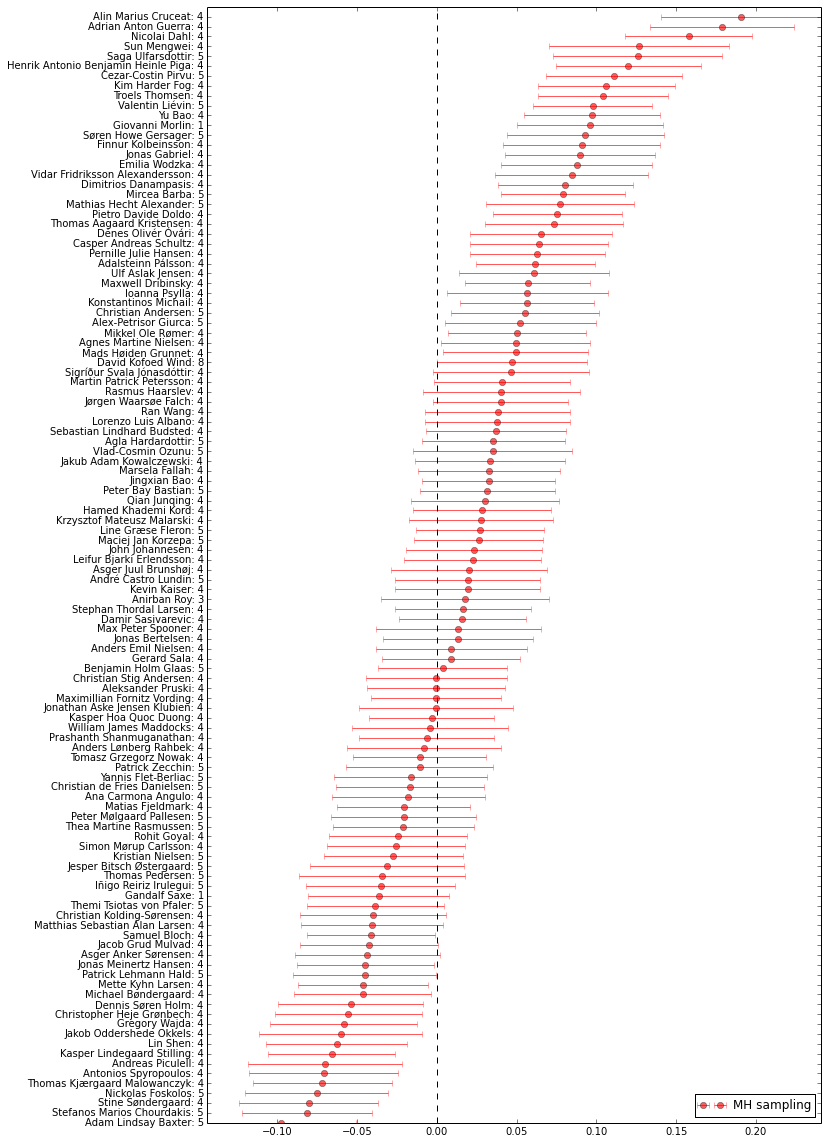

In [139]:
plot_bias(a1_data,a1_result)

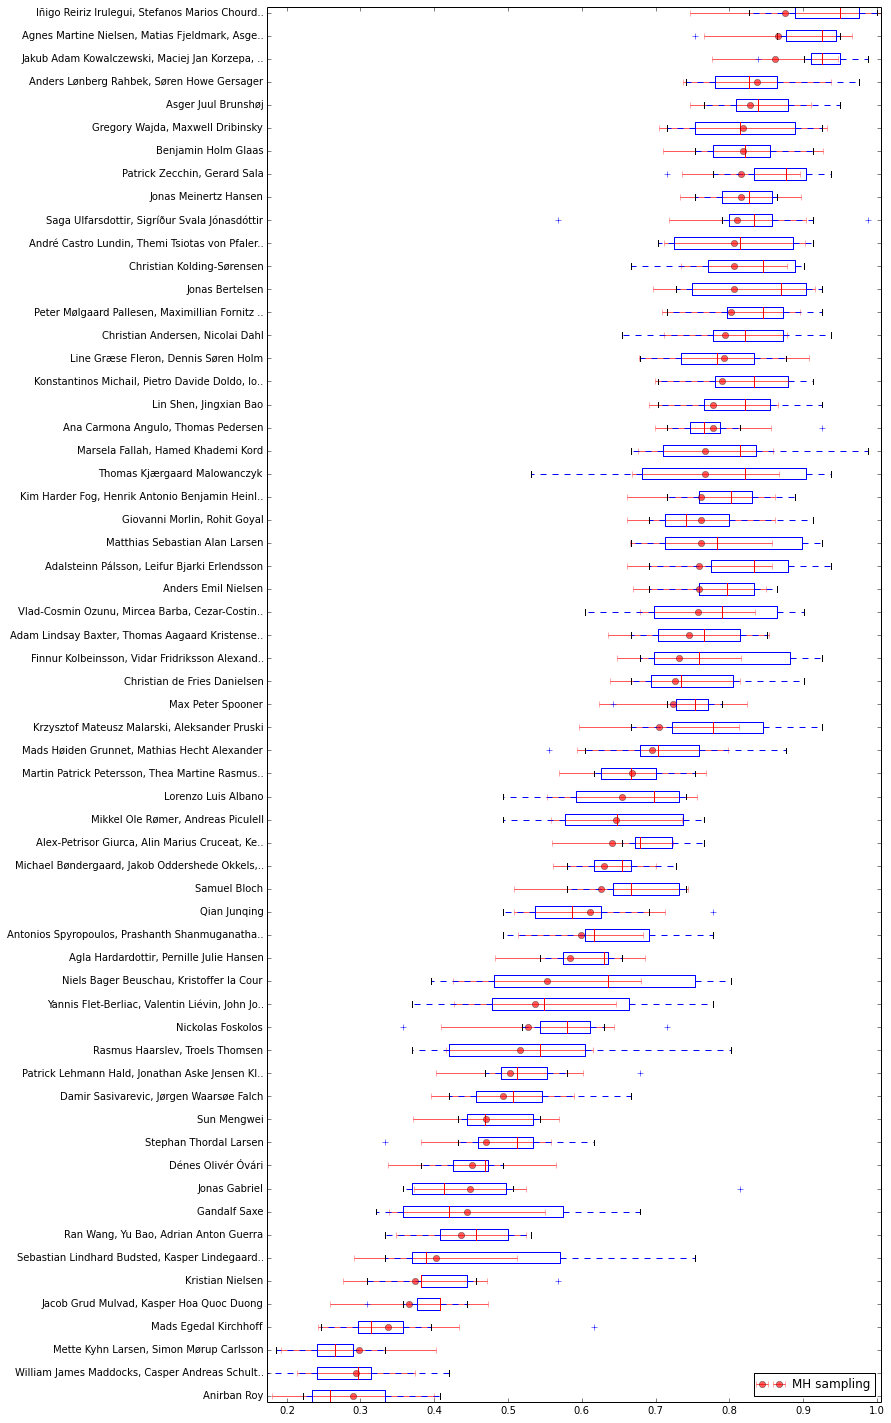

In [138]:
plot_handin_score(a1_data,a1_result)

## Assignment 2

In [110]:
a2 = data_model.Assignment.objects.get(title="Databases and Streaming")

a2_data = fetch_data(a2)

a2_result = MH_model(a2_data,7000,3000)

10000 out of 10000
Wall time: 199.159035


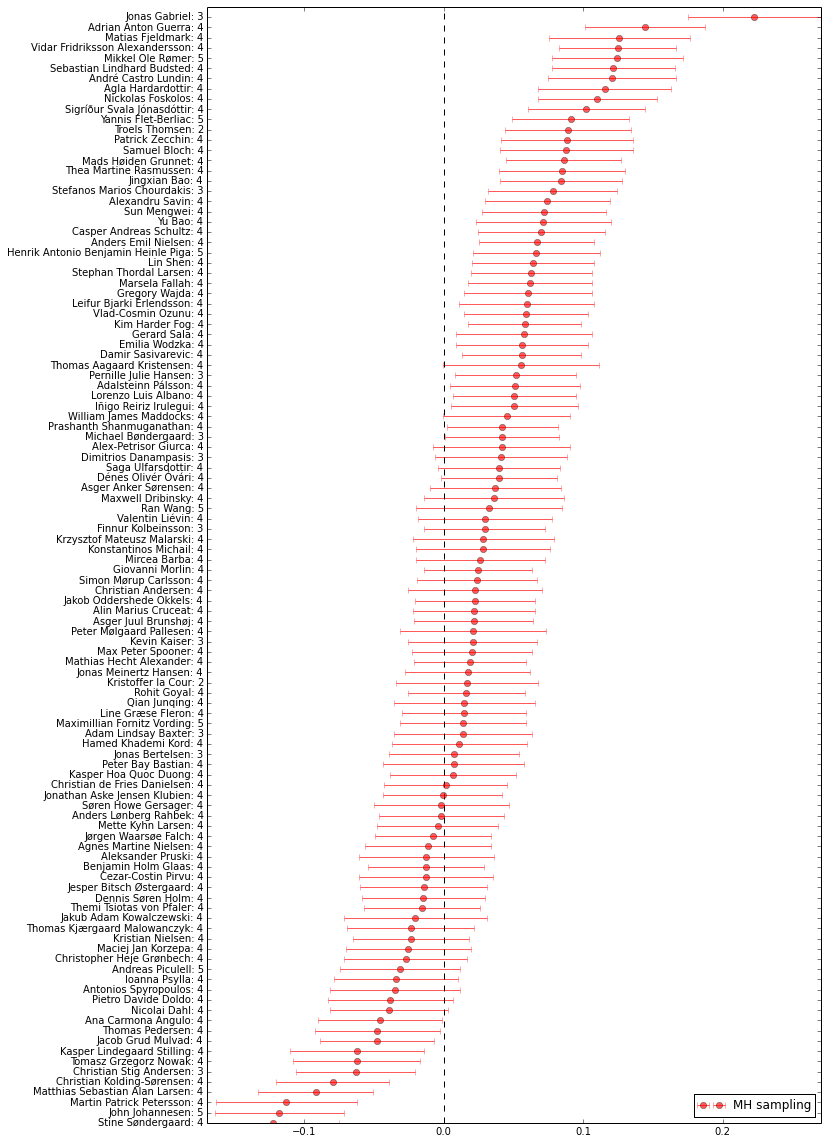

In [137]:
plot_bias(a2_data,a2_result)

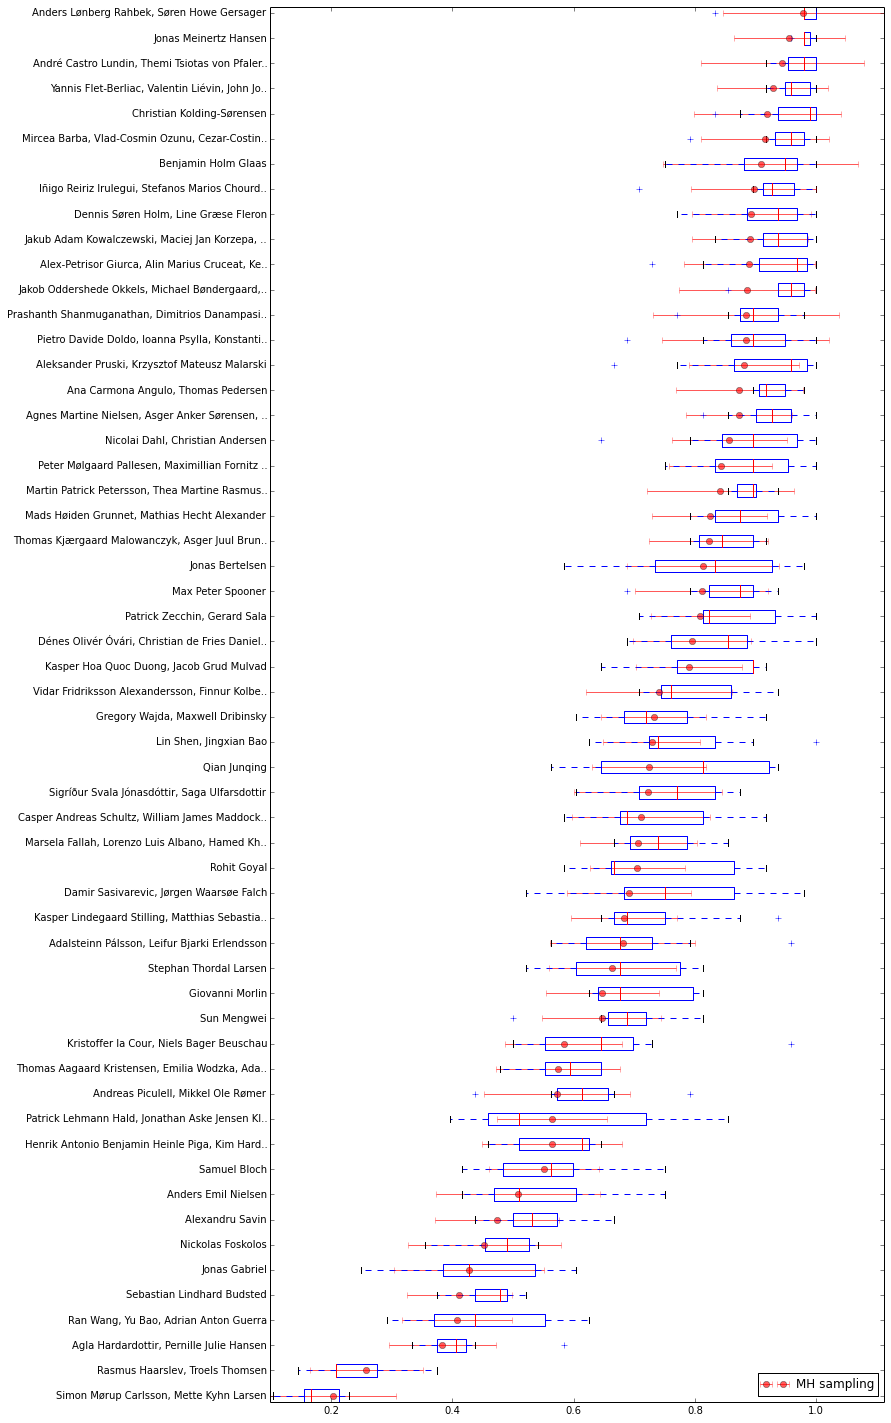

In [136]:
plot_handin_score(a2_data,a2_result)

## Assignment 3

In [111]:
a3 = data_model.Assignment.objects.get(title="Big Data and Deep Learning")

a3_data = fetch_data(a3)

a3_result = MH_model(a3_data,7000,3000)

10000 out of 10000
Wall time: 215.394292


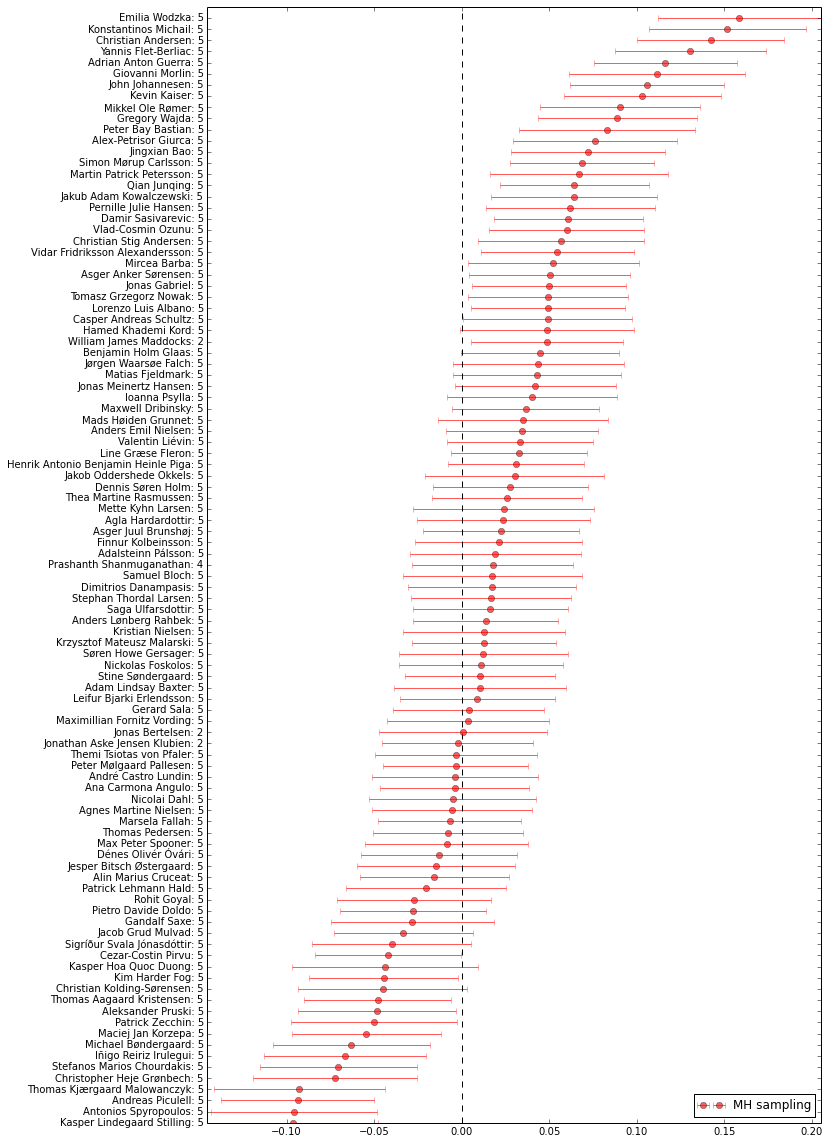

In [81]:
plot_bias(a3_data,a3_result)

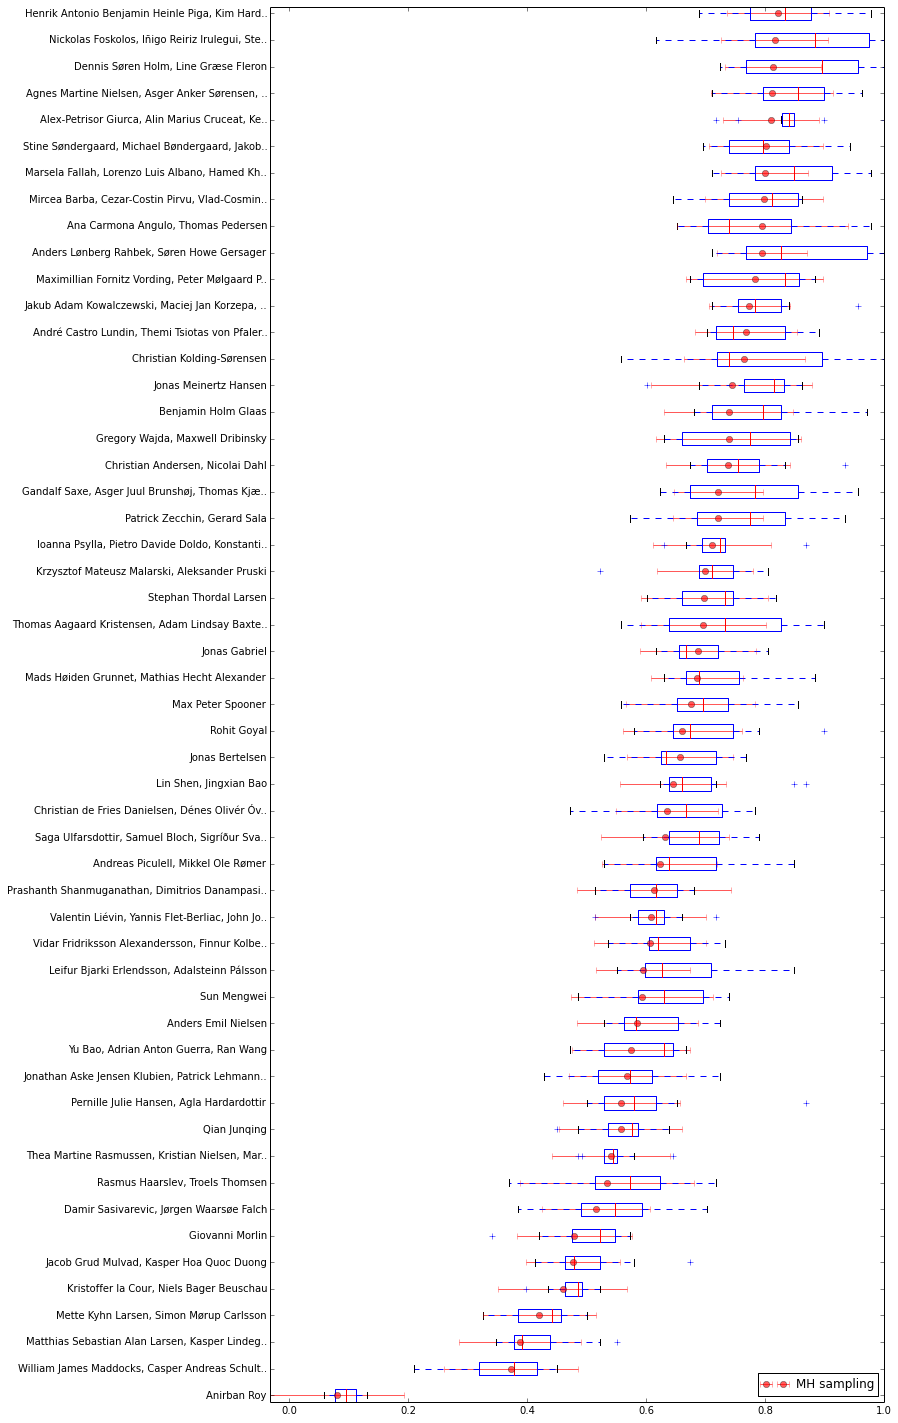

In [135]:
plot_handin_score(a3_data,a3_result)

## Assignment 4

In [112]:
a4 = data_model.Assignment.objects.get(title="Your Choice of Subject")

a4_data = fetch_data(a4)

a4_result = MH_model(a4_data,7000,3000)

10000 out of 10000
Wall time: 234.907156


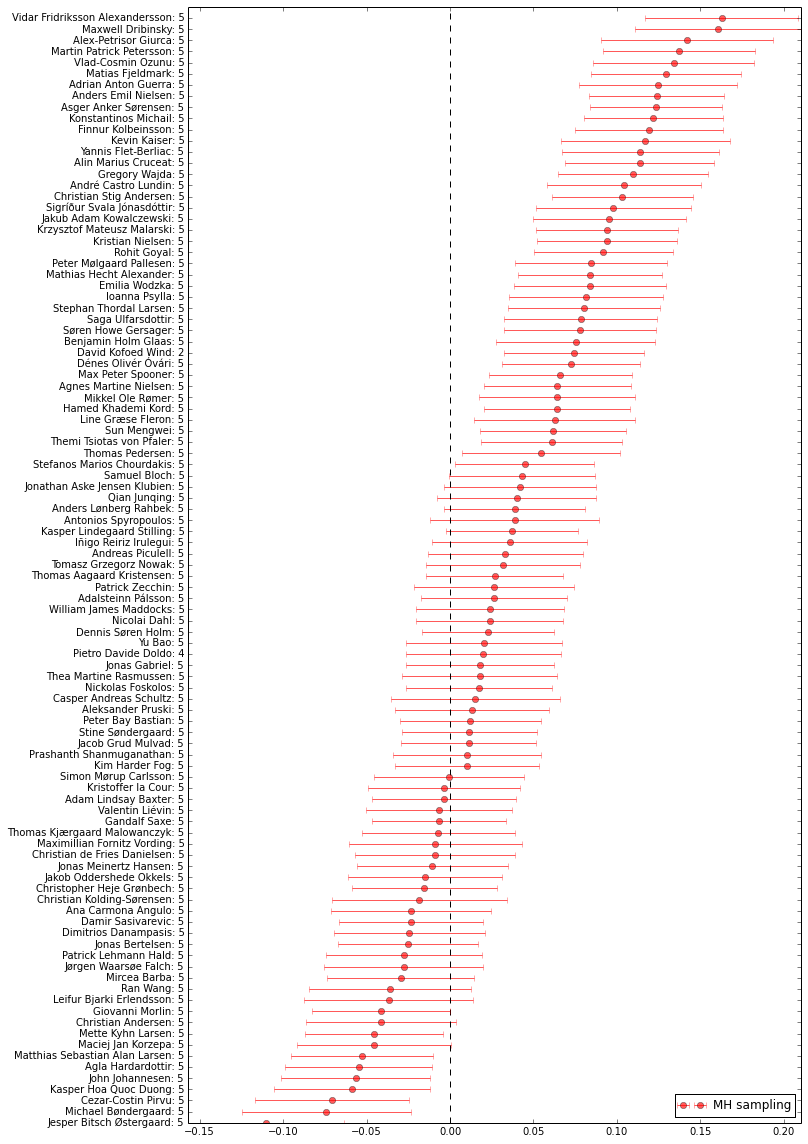

In [113]:
plot_bias(a4_data,a4_result)

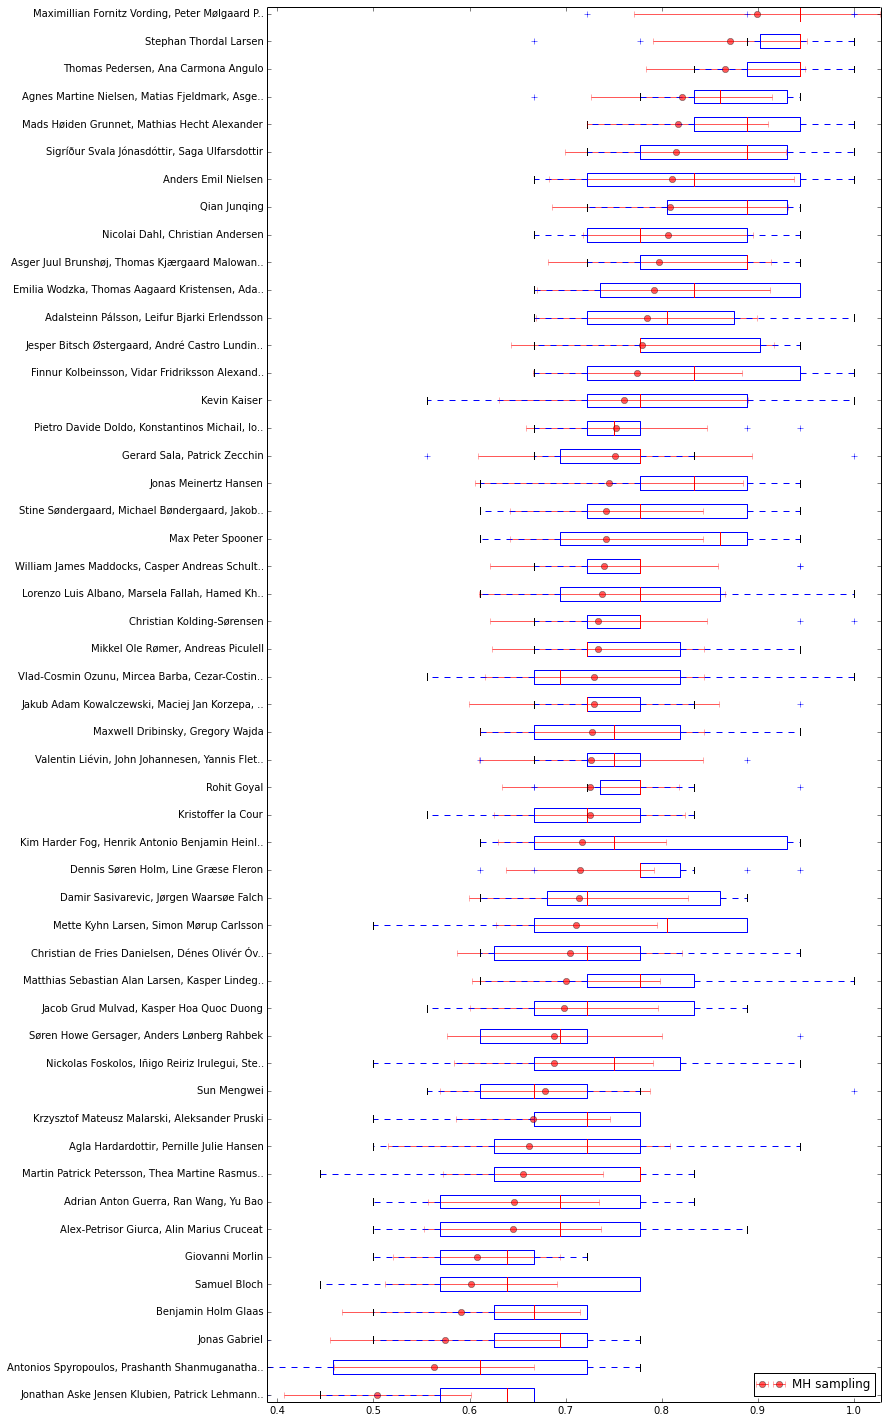

In [134]:
plot_handin_score(a4_data,a4_result)

In [90]:
def plot_all_grader_bias(data_result):
    
    grader_bias = defaultdict(list)
    grader_n_h = defaultdict(list)
    
    for data,result in data_result:

        for id, g in data.graders.iteritems():
            n_h = len(data.graders[id].handins)
            grader_n_h[id].append(n_h)
            grader_bias[id].append(np.mean(result['u_g'][id]))

    scores = list()
    for name, values in grader_bias.iteritems():
        l = user_name(ObjectId(name)) + ": %i, %i" % (len(grader_n_h[name]),sum(grader_n_h[name]))
        scores.append((l,values))
    
    scores.sort(key=lambda x:np.mean(x[1]))
    
    ax = plt.subplot(111)
    
    model_1 = map(lambda x : x[1],scores)
    model_m = map(lambda x : np.mean(x[1]),scores)
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.boxplot(model_1,positions=y, vert=False)
    plt.plot(model_m,y,'or',label="Average Bias",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*5])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.title("Assignments Bias")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader: [Graded assignments], [Graded handins]")
    plt.xlabel("Bias")
    plt.show()

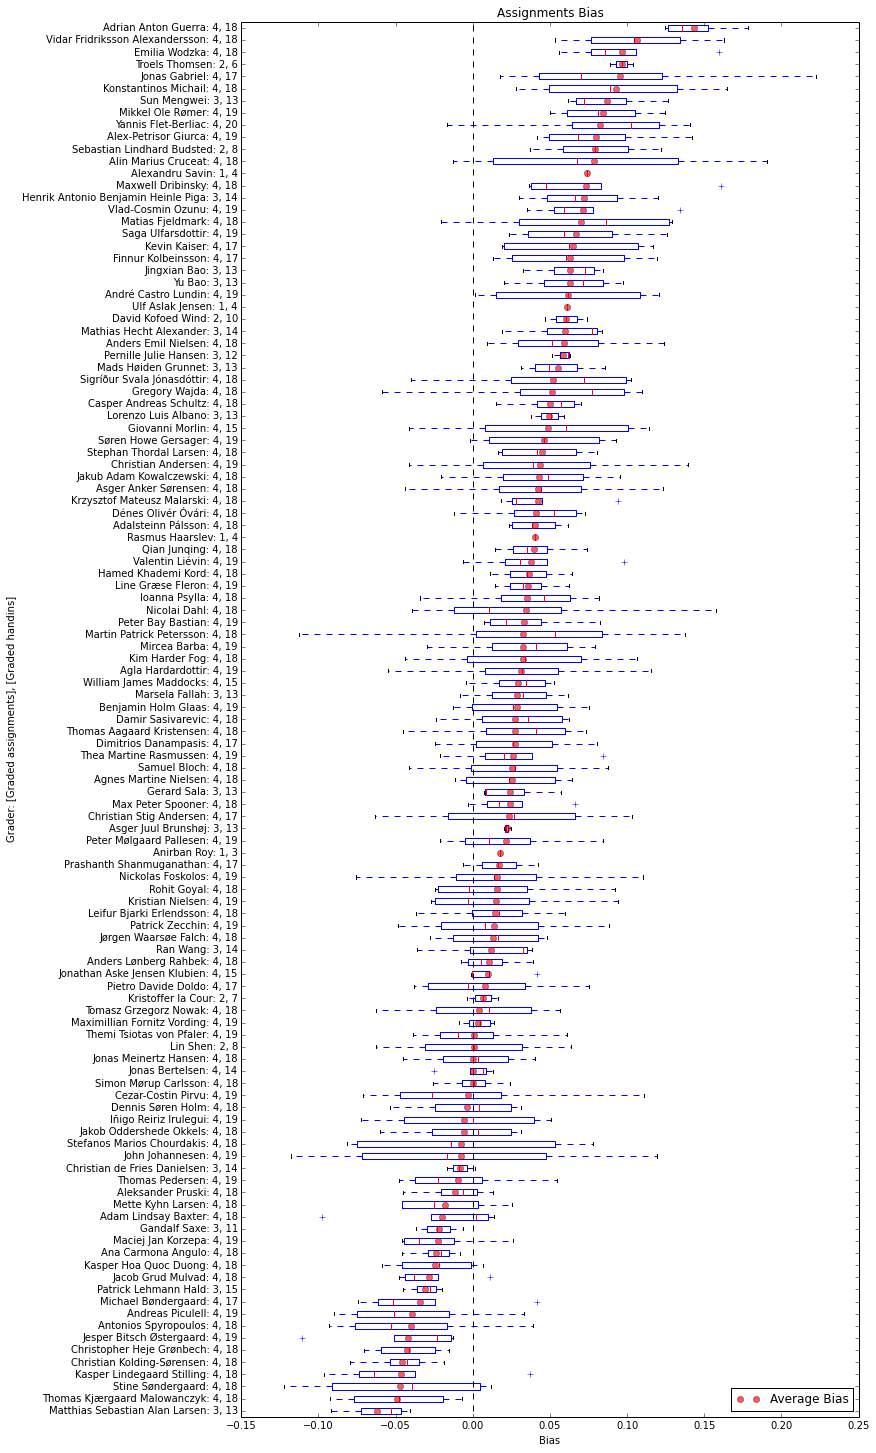

In [115]:
plot_all_grader_bias([(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)])

In [105]:
def print_handin(ass_data,name_):
    for i, (data,result) in enumerate(ass_data):
        print "Assignment %i: " % (i+1),
        u_id = user_id(name_)
        scores = list()

        for h, handin in data.handins.iteritems():

            model_handin = data_model.Handin.objects.get(id=ObjectId(h))

            for student in model_handin.students:
                if student.id == u_id:
                    print np.mean(result['u_h'][h])
                    break
            else:
                continue  # executed if the loop ended normally (no break)
            break         


In [100]:
def print_bias(course_data,ass_data,name_in):

    print "Course:",
    sr = get_sorted_result(course_data[0],course_data[1])

    for name, value in sr:
        if name_in in name:
            print value

    sum_c = 0.0
    for i , (data,result) in enumerate(ass_data):
        print "Assignment %i:" % (i+1),
        sr = get_sorted_result(data,result)

        for name, value in sr:
            if name_in in name:
                print value
                sum_c = sum_c + value
    print "Mean: %f" % (sum_c / 4.0)

In [101]:
collected_ass_data = [(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)]
collected_course_data = (course_data,course_result)

## closer look at  Jesper Bitcsh Østergaard

In [126]:
print_bias(collected_course_data,collected_ass_data,u'Jesper Bitsch Østergaard')

Course: -0.0814573131803
Assignment 1: -0.031986431637
Assignment 2: -0.00822064659192
Assignment 3: -0.0147437026241
Assignment 4: -0.105381714581
Mean: -0.040083


It seems that the bias in assignment 4 have a very heavy influence on the bias of the entire course which is not ideal

In [127]:
print_handin(collected_ass_data,u'Jesper Bitsch Østergaard')

Assignment 1:  0.810502493521
Assignment 2:  0.923179046601
Assignment 3:  0.775230577292
Assignment 4:  0.778376129756


## Closer look at André Castro Lundin

In [107]:
print_bias(collected_course_data,collected_ass_data,u'Andr\xe9 Castro Lundin')

Course: 0.13035711185
Assignment 1: 0.0148374185319
Assignment 2: 0.117983705759
Assignment 3: -0.0039799659365
Assignment 4: 0.106411823646
Mean: 0.058813


The same as previously but this time it is in the positive direction

In [108]:
print_handin(collected_ass_data,u'Andr\xe9 Castro Lundin')

Assignment 1:  0.810502493521
Assignment 2:  0.923179046601
Assignment 3:  0.775230577292
Assignment 4:  0.778376129756


## Closer look at Jonas Gabriel

In [210]:
print_bias(collected_course_data,collected_ass_data,u'Jonas Gabriel')

Course: 0.00842612940583
Assignment 1: 0.0674363303694
Assignment 2: 0.133248974116
Assignment 3: 0.0333695106971
Assignment 4: 0.00804887030474
Mean: 0.060526


As we can see here the Grader is very much positive biased but if the model is used on the entire course the grader is presented as being netural even though that it is not the case.

In [257]:
print_handin(collected_ass_data,u'Jonas Gabriel')

Assignment 1:  0.449699645118
Assignment 2:  0.436267808366
Assignment 3:  0.681604338848
Assignment 4:  0.602263857121


## Closer look at Adrian Anton Guerra

In [211]:
print_bias(collected_course_data,collected_ass_data,u'Adrian Anton Guerra')

Course: 0.0851253963701
Assignment 1: 0.133563773873
Assignment 2: 0.0941644498255
Assignment 3: 0.0949272921091
Assignment 4: 0.0804293961701
Mean: 0.100771


Here we see a very positive biased person where the model is actually not giving the user grader as high a bias as he actully should have

In [260]:
print_handin(collected_ass_data,u'Adrian Anton Guerra')

Assignment 1:  0.444009850962
Assignment 2:  0.432343705993
Assignment 3:  0.576760585937
Assignment 4:  0.647005018607


## Closer look at myself, Thomas Kjærgaard Malowanczyk

In [212]:
print_bias(collected_course_data,collected_ass_data,u'Thomas Kjærgaard Malowanczyk')

Course: -0.0155012796217
Assignment 1: -0.0499590380997
Assignment 2: -0.0141316439247
Assignment 3: -0.0690994921892
Assignment 4: -0.0118984253693
Mean: -0.036272


Here we see a more normal bias where I have received a negtive bias in most assignments. But the bias from the entore course is still lower than any of the bias in the assignments.

With this we can conclude that using MCMC on the entire course does not provide better result even though it provide more data.
The reson for the extreme result is hard to define as it is an unsubervised method so the underlying reasons in MCMC is not definable.
It can be assumed that taking MCMC over multiple assignments introduces more variables as each assignment can differe widely in both the subject, quality of the questions and the knowledge of the graders in both the subject and their abillity to grade.

The next question is if the same problem arrises as we look at handins as a question/task instead of a collection of questions.

In [258]:
print_handin(collected_ass_data,u'Thomas Kjærgaard Malowanczyk')

Assignment 1:  0.762258330788
Assignment 2:  0.809269609188
Assignment 3:  0.729196510121
Assignment 4:  0.804193526054


## Closer look at Christopher Heje Grønbech

In [263]:
print_bias(collected_course_data,collected_ass_data,u'Christopher Heje Grønbech')

Course: -0.012602762471
Assignment 1: -0.0390709204504
Assignment 2: -0.0183723836915
Assignment 3: -0.0528738302866
Assignment 4: -0.0092508413823
Mean: -0.029892


In [262]:
print_handin(collected_ass_data,u'Christopher Heje Grønbech')

Assignment 1:  0.799938550192
Assignment 2:  0.8401262273
Assignment 3:  0.773714690198
Assignment 4:  0.892798337291


## Closer look at Peter Mølgaard Pallesen

In [128]:
print_bias(collected_course_data,collected_ass_data,u'Peter Mølgaard Pallesen')

Course: 0.107652610084
Assignment 1: -0.0160829262109
Assignment 2: 0.0256505466343
Assignment 3: -0.00344141474963
Assignment 4: 0.0924007413103
Mean: 0.024632


In [129]:
print_handin(collected_ass_data,u'Peter Mølgaard Pallesen')

Assignment 1:  0.804733882904
Assignment 2:  0.840362668179
Assignment 3:  0.765124472597
Assignment 4:  0.88872585947
